# NMF Practical Work

**Umut Simsekli, Bertrand David, Paul Magron** 

Telecom Paris

In [1]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
# ms.use('seaborn-muted')
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


<Figure size 640x480 with 0 Axes>

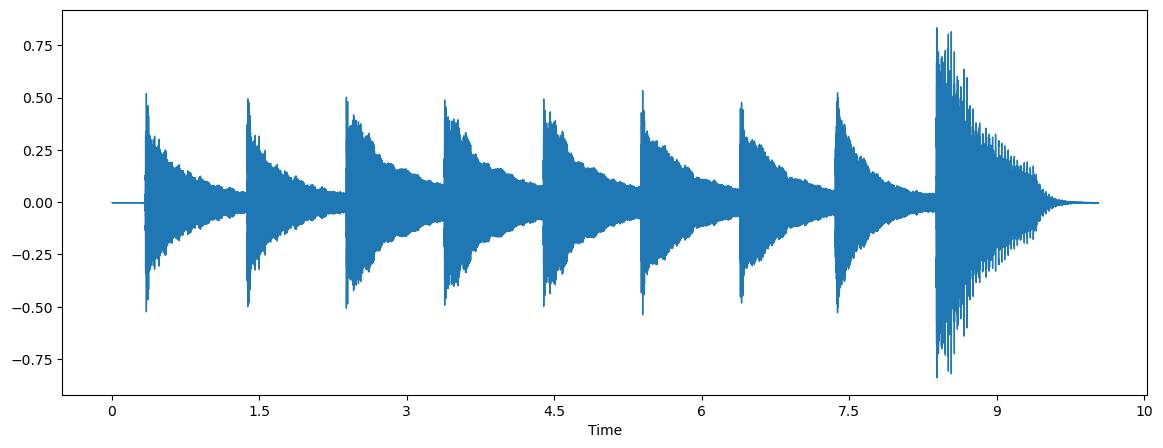

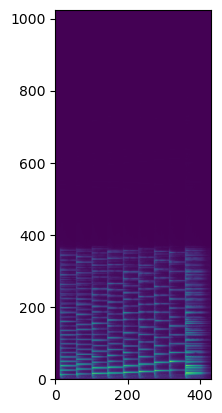

In [2]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [3]:
# Implement MUR for NMF with beta-divergence 



In [3]:
# Example reconstruction
y_hat = librosa.istft(Xstft)
ipd.Audio(y_hat, rate=sr)


In [4]:
def build_signal(notes, Fs):
    """
%  Signal synthesis from piano isolated notes
%  
% 
% Inputs :
%     notes : matrix of notes with 4 lines : pitch, t onset, durations and
%     velocity
%     Fs : sample rate (in Hz)
%
% Outputs :
%     x : synthesis signal
    """
    pitch = notes[0, :]
    t_on = notes[1, :]
    durations = notes[2, :]
    vel = notes[3, :]
    Nnotes = len(pitch)
    Lsig = int((t_on[-1]+durations[-1])*Fs)
    x = np.zeros(Lsig)
    for n in range(Nnotes):
        # Get midi index
        ind_pitch = pitch[n]
        Lnote = int(durations[n]*Fs)
        
        # Read piano note
        xt, sr = librosa.load('data/{}.wav'.format(str(int(ind_pitch))))
        xt = librosa.resample(xt, sr, Fs)
        xt = xt[:Lnote] * vel[n]
        
        # Fill the current melodic line
        deb = int(t_on[n]*Fs)
        fin = deb + Lnote
        x[deb:fin] += xt
    return x

# 1 Non-Negative Matrix Factorization with β-divergence

When we differentiate the cost function, we obtain:

$$
\frac{\partial d_\beta}{\partial W} = 0 = - \frac{(\beta - 1) X (WH)^{\beta - 2} H^T}{\beta - 1} + \frac{\beta (WH)^{\beta - 1} H^T}{\beta}
$$

Simplifying, we get:

$$
\frac{\partial d_\beta}{\partial W} = -X (WH)^{\beta - 2} H^T + (WH)^{\beta - 1} H^T
$$

So when we do a gradient descent on $(W)$:

$$
W \leftarrow W - \eta_W \left( -X (WH)^{\beta - 2} H^T + (WH)^{\beta - 1} H^T \right)
$$

If we take $\eta_W = \frac{W}{(WH)^{\beta - 1} H^T}$, we then have:

$$
W \leftarrow W - \frac{W}{(WH)^{\beta - 1} H^T} \left( -X (WH)^{\beta - 2} H^T + (WH)^{\beta - 1} H^T \right)
$$

Simplifying further, we get:

$$
W \leftarrow W + W \circ \frac{X (WH)^{\beta - 2} H^T}{(WH)^{\beta - 1} H^T} - W
$$

Therefore, the multiplicative update rule for $W$ is:

$$
W \leftarrow W \circ \frac{X (WH)^{\beta - 2} H^T}{(WH)^{\beta - 1} H^T}
$$

Now we do the same for $H$:

$$
\frac{\partial d_\beta}{\partial H} = 0 = - \frac{(\beta - 1) W^T (X (WH)^{\beta - 1})}{\beta - 1} + \frac{\beta W^T (WH)^{\beta - 1}}{\beta}
$$

Simplifying, we get:

$$
\frac{\partial d_\beta}{\partial H} = - W^T (X (WH)^{\beta - 2}) + W^T (WH)^{\beta - 1}
$$

So we have when doing a gradient descent:

$$
H \leftarrow H - \eta_H \left( -W^T (X \circ (WH)^{\beta - 2}) + W^T (WH)^{\beta - 1} \right)
$$

If we take $\eta_H = \frac{H}{W^T (WH)^{\beta - 1}}$, then we obtain:

$$
H \leftarrow H - \frac{H}{W^T (WH)^{\beta - 1}} \left( -W^T (X \circ (WH)^{\beta - 2}) + W^T (WH)^{\beta - 1} \right)
$$

Simplifying further, we get:

$$
H \leftarrow H + H \circ \frac{W^T (X \circ (WH)^{\beta - 2})}{W^T (WH)^{\beta - 1}} - H
$$

Therefore, the multiplicative update rule for $H$ is:

$$
H \leftarrow H \circ \frac{W^T (X \circ (WH)^{\beta - 2})}{W^T (WH)^{\beta - 1}}
$$


# 2 Variations on a simple example

## 2.1 Construction of the simple example

In [117]:
Fe = 8e3
Nfft = 512
f0 = [370, 277] # C, E

print(Fe/Nfft)

freq = np.arange(0, Fe, Fe/Nfft)
Kr = np.where(freq < Fe/2)[0]
w_width_hz = 370
w_width = int(w_width_hz / Fe * Nfft)
w = np.hanning(w_width)
W_r = []
for f0_r in f0:
    W = np.zeros(freq.size)
    for k in Kr:
        if k*f0_r/Fe > 0.5:
            break
        a_k = np.exp(-k/len(Kr))
        freq_left = f0_r*k - w_width_hz/2
        N_left = max(0, int(freq_left / Fe * Nfft))
        freq_right = f0_r*k + w_width_hz/2
        N_right = min(Nfft, int(freq_right / Fe * Nfft))
        if N_left < N_right:
            segment_length = N_right - N_left
            if segment_length > w.size:
                w_padded = np.pad(w, (0, segment_length - w.size), 'constant')
            else:
                w_padded = w[:segment_length]
            W[N_left:N_right] += a_k * w_padded
    W_r.append(W)

Ws = np.array(W_r).T
# plt.plot(W_r[0])
# plt.plot(W_r[1])
# plt.plot(w)
# plt.plot(np.exp(-Kr/len(Kr)))
# plt.xlim([0, 256])
# plt.show()




15.625


In [118]:
Fh = Fe/(Nfft/4)
DeltaT = 0.5
DeltaT = round(DeltaT*Fh)
t = np.arange(DeltaT-1)/Fh
tau = 0.3
h = np.exp(-t/tau)
z = np.zeros(DeltaT-1)

# Pad h and z to the same length
Hs = np.array([np.concatenate([h, z, h]), np.concatenate([z, h, h])])

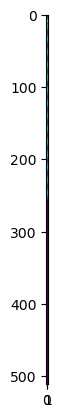

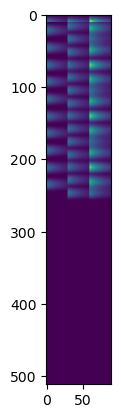

In [119]:
plt.imshow(Ws)
plt.show()

Xs = np.dot(Ws, Hs)
plt.imshow(Xs)

In [121]:

def MUR(X, k, beta=2, iterations=100):
    X = X + 1e-6
    # Initialisation de W et H
    i, j = X.shape
    W = np.random.rand(i, k)
    H = np.random.rand(k, j)
    cost_functions = []
    for _ in range(iterations):

        X_hat = W@H +1e-6
        tmp = X * np.power(X_hat, beta-2)
        tmp = tmp @ H.T
        tmp = tmp / (np.power(X_hat, beta-1)@ H.T)
        W = W * tmp

        X_hat = W @ H +1e-6
        tmp = X * np.power(X_hat, beta-2)
        tmp = W.T @ tmp
        tmp = tmp / (W.T @ np.power(X_hat, beta-1))
        H = H * tmp

        # cost function
        if beta == 1:
            cost = X_hat**beta / beta
        else:
            cost = X**beta / beta * (beta-1) - X * X_hat**(beta-1) / (beta-1) + X_hat**beta / beta
        cost_functions.append(cost.sum())
        # normalisation
        W = W / W.sum(axis=0)
        H = H / H.sum(axis=1)[:, None]

    return W, H, cost_functions

W, H, C = MUR(Xs, 2, beta=2)


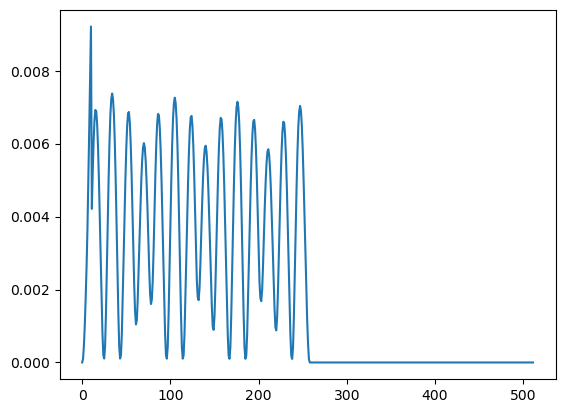

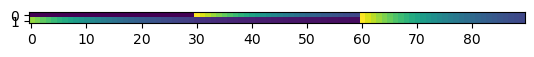

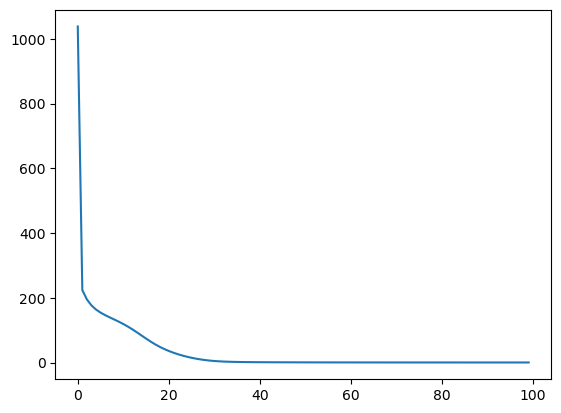

In [ ]:
plt.imshow(W)
plt.show()
plt.imshow(H)
plt.show()
plt.plot(C)
plt.show()